In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 14:10:42.076431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 14:10:42.155783: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 14:10:42.500842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 14:10:42.500897: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [5]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [6]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 50

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [7]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12157
12157
12157
12157
12157
12157
12157
12157


In [8]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000


############
# HITS_bot #
############

hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )

print('hits_bot length: ', len(hits_bot_S))


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])



# X and Y for the classifier
X_hits_bot = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_hits_bot = scaler.fit_transform(X_hits_bot)

del hits_bot_B
del hits_bot_S



############
# HITS_top #
############

hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )

print('hits_top length: ', len(hits_top_S))


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])



# X and Y for the classifier
X_hits_top = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_hits_top = scaler.fit_transform(X_hits_top)

del hits_top_B
del hits_top_S



###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S




###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S



# close the h5 files
f_B.close()
f_S.close()





###################
# CONCATENATE ALL #
###################

X_mon = np.concatenate([X_hits_bot,X_hits_top,X_peakS1,X_peakS2],axis=1)

del X_hits_bot
del X_hits_top
del X_peakS1
del X_peakS2

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

hits_bot length:  121
hits_top length:  127
max_pS1_both lenght:  169
max_pS2_both lenght:  2244

X_mon_train :  (9999, 2661)
y_mon_train :  (9999,)
X_mon_val :  (3334, 2661)
y_mon_val :  (3334,)
X_mon_test :  (6667, 2661)
y_mon_test :  (6667,)



### CLASSIFIER

In [9]:
X_mon_train.shape[1]

2661

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               681472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

2023-05-18 14:13:55.936019: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-18 14:13:55.936035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pcmadrid): /proc/driver/nvidia/version does not exist
2023-05-18 14:13:55.936292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


79/79 [==============================] - 1s 6ms/step - loss: 0.3642 - accuracy: 0.8416 - val_loss: 0.2571 - val_accuracy: 0.8950
Epoch 2/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.2766 - accuracy: 0.8900 - val_loss: 0.2580 - val_accuracy: 0.8992
Epoch 3/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.2690 - accuracy: 0.8943 - val_loss: 0.2450 - val_accuracy: 0.9001
Epoch 4/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.2553 - accuracy: 0.8993 - val_loss: 0.2440 - val_accuracy: 0.9040
Epoch 5/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.2448 - accuracy: 0.9030 - val_loss: 0.2372 - val_accuracy: 0.9046
Epoch 6/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.2384 - accuracy: 0.9063 - val_loss: 0.2333 - val_accuracy: 0.9088
Epoch 7/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.2287 - accuracy: 0.9128 - val_loss: 0.2324 - val_accuracy: 0.9100
Epoch 8/1500
79/79 

79/79 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9718 - val_loss: 0.5503 - val_accuracy: 0.8971
Epoch 116/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.1021 - accuracy: 0.9618 - val_loss: 0.4849 - val_accuracy: 0.8983
Epoch 117/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0845 - accuracy: 0.9727 - val_loss: 0.5078 - val_accuracy: 0.8965
Epoch 118/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0784 - accuracy: 0.9716 - val_loss: 0.5458 - val_accuracy: 0.8983
Epoch 119/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.1120 - accuracy: 0.9605 - val_loss: 0.4414 - val_accuracy: 0.8962
Epoch 120/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0983 - accuracy: 0.9659 - val_loss: 0.4016 - val_accuracy: 0.9001
Epoch 121/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.1365 - accuracy: 0.9512 - val_loss: 0.3941 - val_accuracy: 0.8995
Epoch 1

Epoch 172/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0843 - accuracy: 0.9699 - val_loss: 0.5502 - val_accuracy: 0.8965
Epoch 173/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0892 - accuracy: 0.9678 - val_loss: 0.4807 - val_accuracy: 0.9007
Epoch 174/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0938 - accuracy: 0.9695 - val_loss: 0.4882 - val_accuracy: 0.8953
Epoch 175/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9695 - val_loss: 0.5215 - val_accuracy: 0.9007
Epoch 176/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9727 - val_loss: 0.5087 - val_accuracy: 0.9013
Epoch 177/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0944 - accuracy: 0.9680 - val_loss: 0.4140 - val_accuracy: 0.8971
Epoch 178/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0782 - accuracy: 0.9712 - val_loss: 0.5946 - val_accuracy:

Epoch 229/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9626 - val_loss: 0.5657 - val_accuracy: 0.8968
Epoch 230/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 0.9602 - val_loss: 0.5348 - val_accuracy: 0.8980
Epoch 231/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.1036 - accuracy: 0.9576 - val_loss: 0.5885 - val_accuracy: 0.8965
Epoch 232/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0946 - accuracy: 0.9595 - val_loss: 0.5756 - val_accuracy: 0.8911
Epoch 233/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 0.9590 - val_loss: 0.6269 - val_accuracy: 0.8929
Epoch 234/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.1053 - accuracy: 0.9550 - val_loss: 0.5096 - val_accuracy: 0.8887
Epoch 235/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0996 - accuracy: 0.9583 - val_loss: 0.4607 - val_accuracy:

Epoch 286/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9672 - val_loss: 0.6828 - val_accuracy: 0.8959
Epoch 287/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0926 - accuracy: 0.9620 - val_loss: 0.6170 - val_accuracy: 0.8980
Epoch 288/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0830 - accuracy: 0.9640 - val_loss: 0.7400 - val_accuracy: 0.8947
Epoch 289/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0976 - accuracy: 0.9624 - val_loss: 0.4970 - val_accuracy: 0.8977
Epoch 290/1500
79/79 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9585 - val_loss: 0.5697 - val_accuracy: 0.8992
Epoch 291/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9633 - val_loss: 0.6063 - val_accuracy: 0.8941
Epoch 292/1500
79/79 [==============================] - 0s 4ms/step - loss: 0.0876 - accuracy: 0.9618 - val_loss: 0.6225 - val_accuracy:

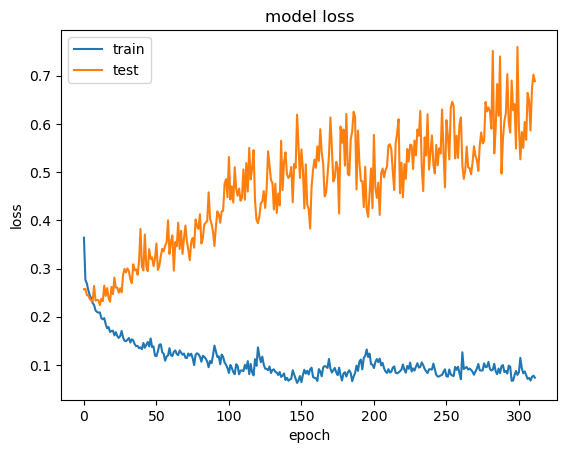

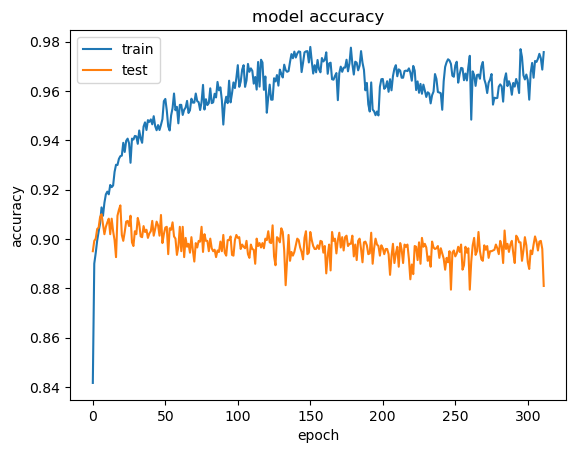

209/209 [==============================] - 0s 605us/step


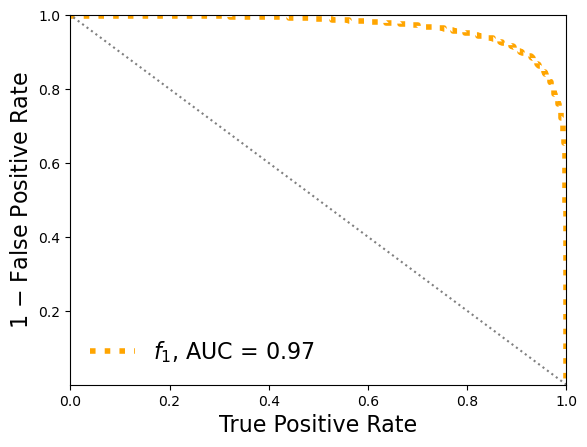

In [10]:
#######
# DNN #
#######

n_features = X_mon_train.shape[1]

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=n_features))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu', input_dim=n_features))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))



model.summary()



# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300, restore_best_weights=True)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


batch_size = 128
tot_epochs = 1500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()





#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'DNN-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_DNN = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_DNN = dict()
tpr_DNN = dict()
roc_auc_DNN = dict()
fpr_DNN, tpr_DNN, _ = roc_curve(y_mon_test, y_pred_DNN)
roc_auc_DNN = auc(fpr_DNN, tpr_DNN)


plt.figure()
plt.plot(tpr_DNN,1-fpr_DNN,label="$f_{1}$, AUC = %0.2f" % roc_auc_DNN,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [11]:
roc_auc_DNN

0.9669724712846943

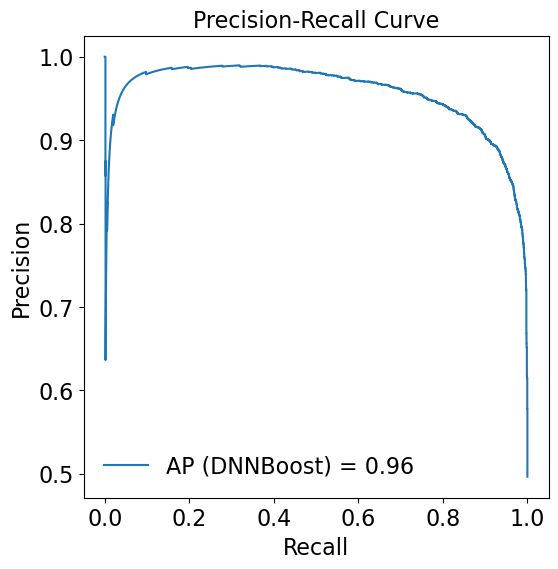

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_DNN, recall_DNN, _ = precision_recall_curve(y_mon_test, y_pred_DNN)
auc_DNN = auc(recall_DNN, precision_DNN)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_DNN, precision_DNN, label=f'AP (DNNBoost) = {auc_DNN:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [13]:
auc_DNN

0.9564086493955238

Classification score:


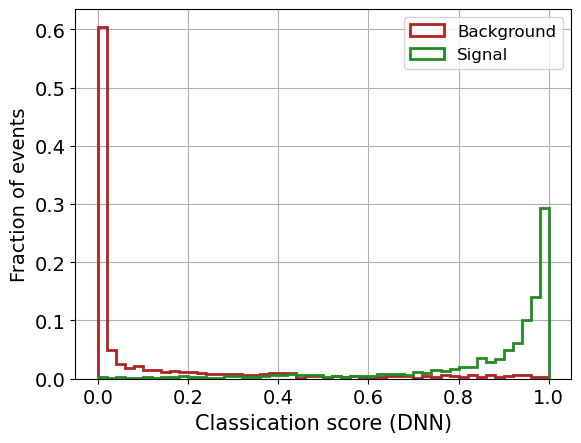

In [14]:
# DNN with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_DNN_SM = []
pred_DNN_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_DNN_SM.append(y_pred_DNN[i,0])
    else:
        pred_DNN_NP.append(y_pred_DNN[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_DNN_SM)/float(len(pred_DNN_SM))
nSM, binsSM, patchesSM = plt.hist(pred_DNN_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_DNN_NP)/float(len(pred_DNN_NP))
nNP, binsNP, patchesNP = plt.hist(pred_DNN_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()